In [1]:
# This notebook inspects the Ca+ and DA data fro mexperiment tagged as HSFP_636970_2022-11-14-12-34-14
# These data are used only to determine parameters for the simulation that the network will be trained on
# The trained model will be simply applied to this data.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timebudget import timebudget
from multiprocessing import Pool

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

import h5py
from rich import print as pprint
from sourcesep.utils.config import load_config

In [2]:
# These are combined responses of autofluorescence, Ca sensor (EGFP), and DA sensor (mApple).

from sourcesep.sim import SimData

paths = load_config(dataset_key="all")
sim = SimData(T=10000, cfg_path=paths["root"] / "sim_HSFP_636970_2022-11-14-12-34-14.toml")
_ = sim.get_S()
_ = sim.get_W()
_ = sim.get_E()
pprint(sim.W_df)

Paths are for dataset tagged: all
Paths are for dataset tagged: all


405     473     561
EGFP    0.1732  0.8143  0.0043
mApple  0.0069  0.0920  0.8972

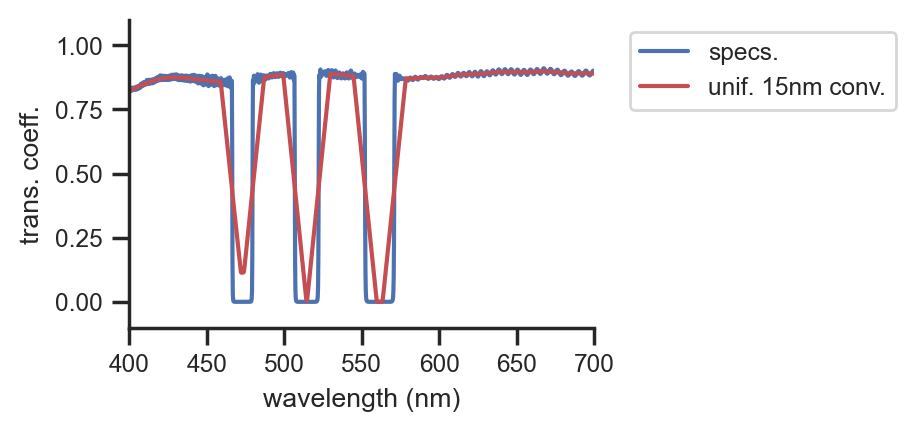

In [3]:
from scipy.ndimage import uniform_filter1d

df_list = []
for lam in [473, 514, 561]:
    df = pd.read_excel(
        paths["spectra"] / f"Semrock_{lam}nm_notch.xlsx", skiprows=13
    )  # Skip the first 10 rows if they contain headers or metadata
    df.columns = ["wavelength", "trans"]
    df_list.append(df)

assert np.all(df_list[0]["wavelength"].values == df_list[1]["wavelength"].values)
assert np.all(df_list[0]["wavelength"].values == df_list[2]["wavelength"].values)

# transmission of each notch should be multiplied for overall transmission
ideal_trans = df_list[0]["trans"] * df_list[1]["trans"] * df_list[2]["trans"]
wavelength = df_list[0]["wavelength"].values

conv_window = 15  # in nm
lam_sampling_rate = np.mean(np.diff(wavelength))
df = pd.DataFrame({"wavelength": wavelength, "ideal_trans": ideal_trans})

df["eff_trans"] = uniform_filter1d(df["ideal_trans"], int(conv_window / lam_sampling_rate))

f, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(df["wavelength"], df["ideal_trans"], c="b", label="specs.")
ax.plot(df["wavelength"], df["eff_trans"], c="r", label="unif. 15nm conv.")
ax.set(xlabel="wavelength (nm)", ylabel="trans. coeff.", xlim=(400, 700), ylim=(-0.1, 1.1))
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

eff_trans = np.interp(sim.L_arr, df["wavelength"], df["eff_trans"])

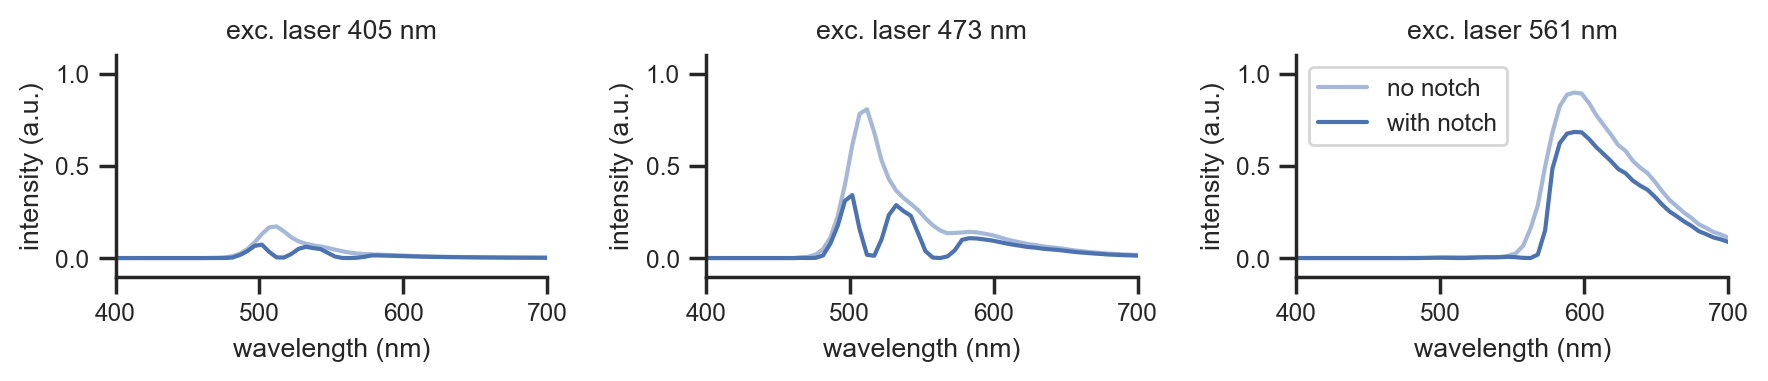

In [4]:
lasers = [473, 514, 561]
S = sim.W.T @ sim.S
S_notch = (sim.W.T @ sim.S) * eff_trans.reshape(1, -1)

f, ax = plt.subplots(1, 3, figsize=(9, 2))
for j in range(3):
    ax[j].plot(sim.L_arr, S[j, :], "-b", alpha=0.5, label="no notch")
    ax[j].plot(sim.L_arr, S_notch[j, :] * eff_trans, "-b", label="with notch")
    ax[j].set(
        xlim=(400, 700),
        ylim=(-0.1, 1.1),
        xlabel="wavelength (nm)",
        ylabel="intensity (a.u.)",
        title=f"exc. laser {sim.W_df.columns.values[j]} nm",
    )

plt.tight_layout()
plt.legend()
plt.show()

In [5]:
paths = load_config(dataset_key="all")
f = h5py.File(paths["root"] / "HSFP_636970_2022-11-14-12-34-14_data_preprocessed.hdf5", "r")
print(f.keys())

xj = {}
xj[0] = f["Channel3"][:]  # 405
xj[1] = f["Channel2"][:]  # 473
xj[2] = f["Channel1"][:]  # 560

t = f["Time"][:]
l = f["Wavelength"][:]

print(f"\nsampling frequency: {1/(np.max(t) / t.size):0.2f} Hz")
print(f"length of recording: {np.max(t)-np.min(t):0.2f} seconds")
print(f"\neach channel has dimensions of {xj[0].shape}")
print(f"min. wavelength: {np.min(l):0.2f} nm")
print(f"max. wavelength: {np.max(l):0.2f} nm")

Paths are for dataset tagged: all
<KeysViewHDF5 ['Channel1', 'Channel2', 'Channel3', 'Time', 'Wavelength']>

sampling frequency: 40.00 Hz
length of recording: 441.64 seconds

each channel has dimensions of (17666, 300)
min. wavelength: 400.00 nm
max. wavelength: 699.00 nm


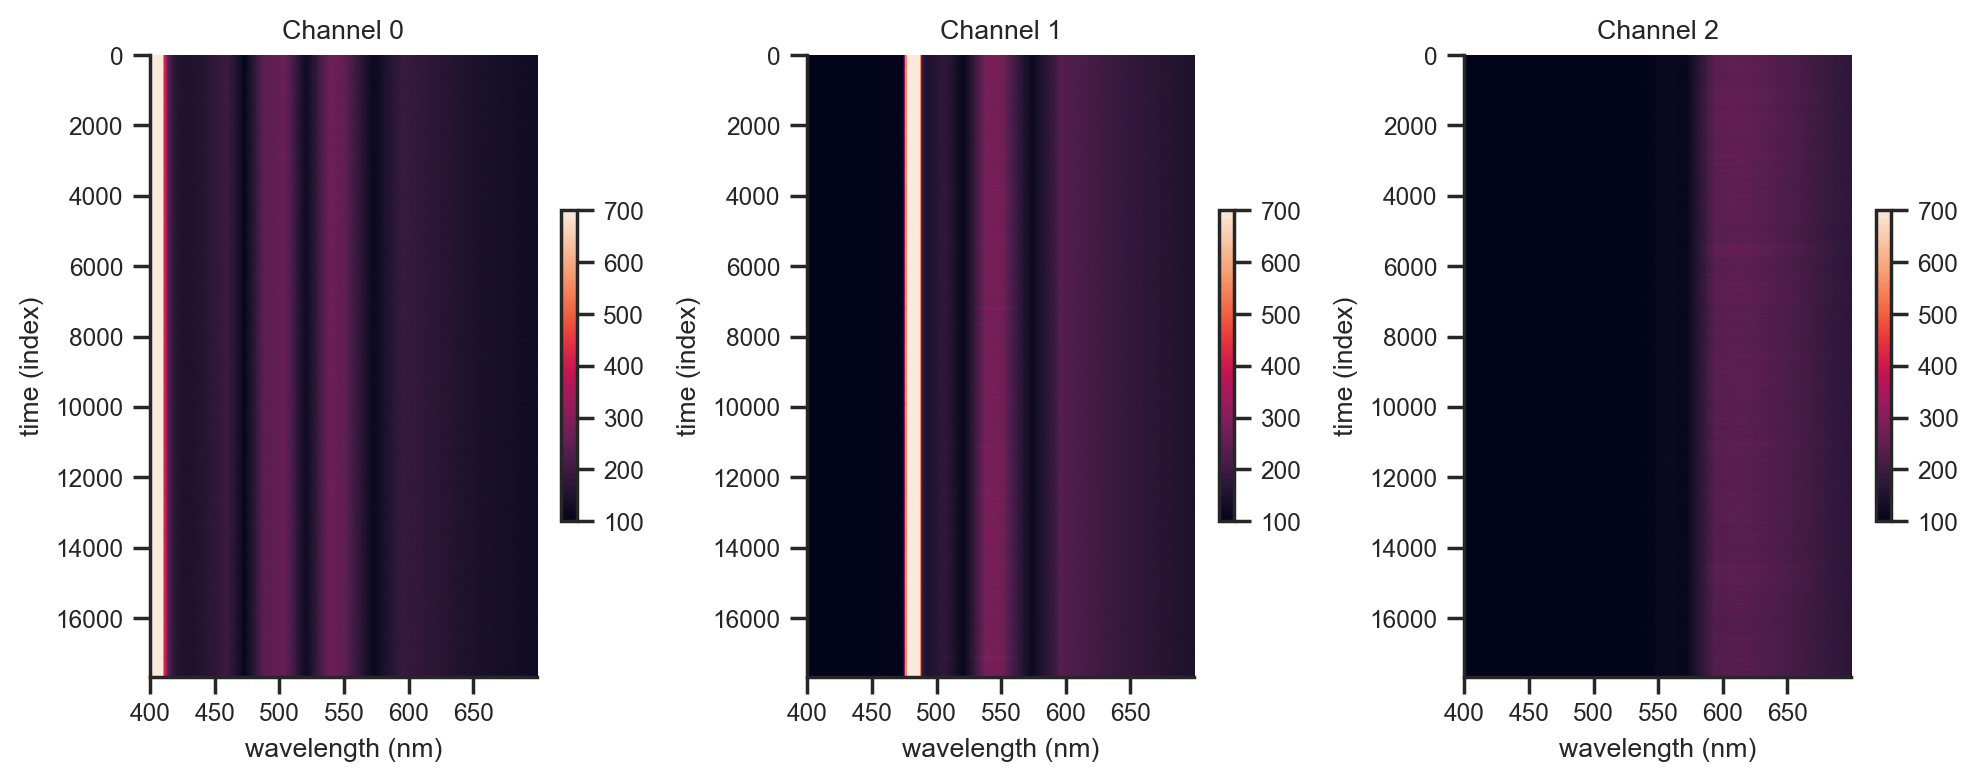

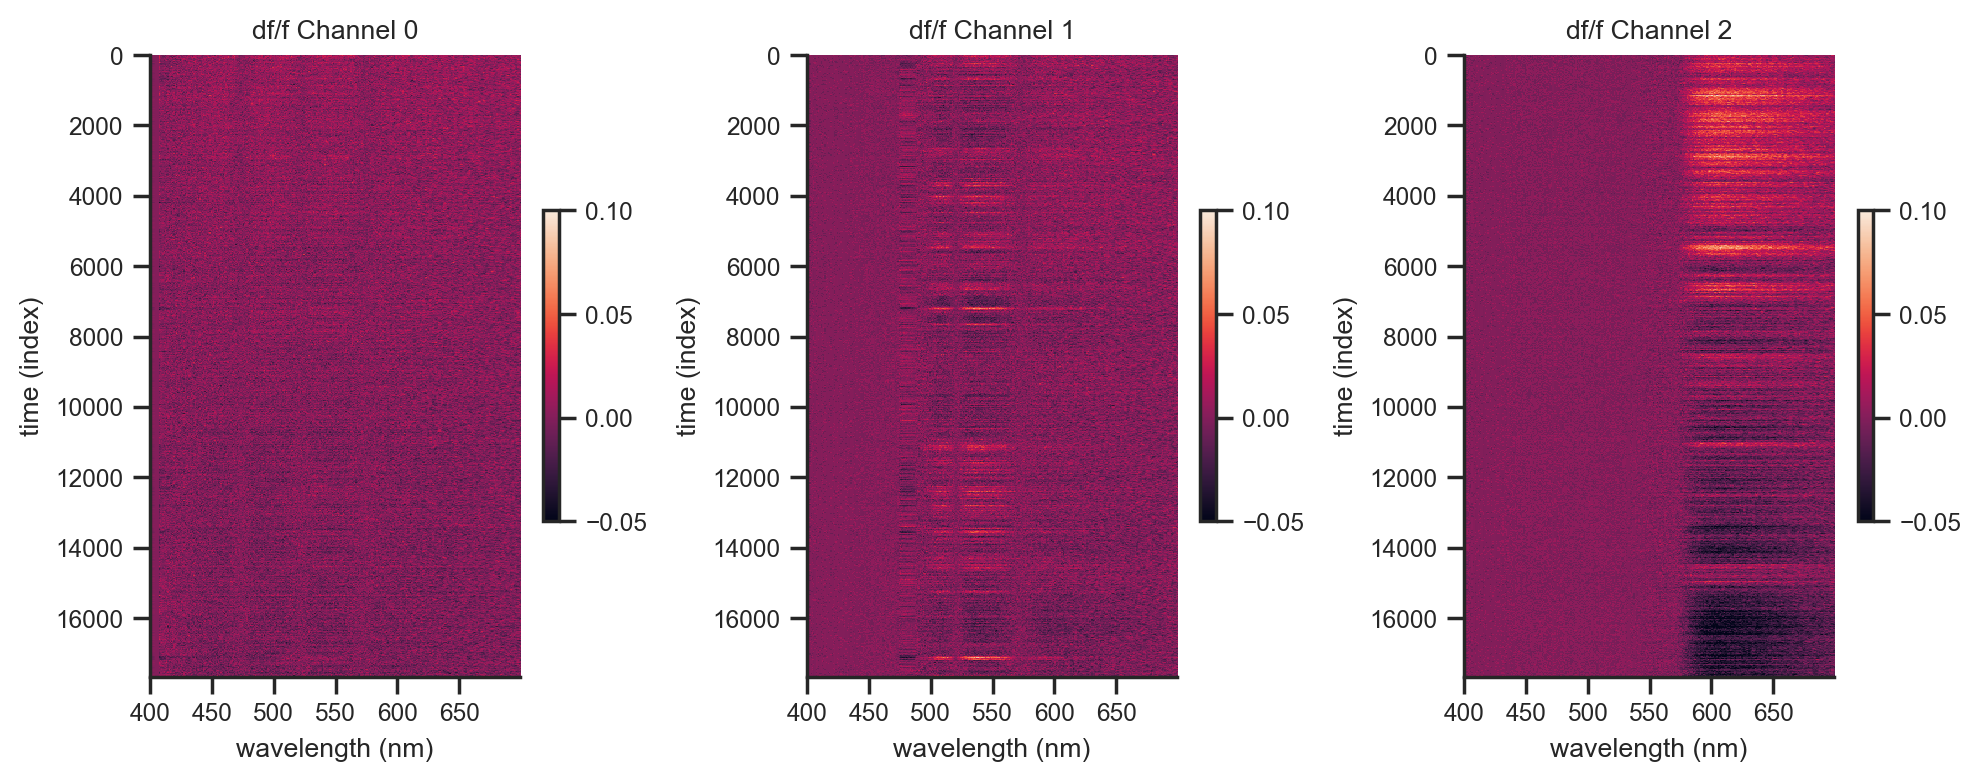

In [6]:
# show raw intensities

f, ax = plt.subplots(1, 3, figsize=(10, 4))
for i in range(3):
    f.colorbar(ax[i].imshow(xj[i], interpolation="nearest", aspect="auto", vmin=100, vmax=700), ax=ax[i], shrink=0.5)
    ax[i].grid(visible=False)
    ax[i].set(xlabel="wavelength (nm)", ylabel="time (index)", title=f"Channel {i}")
    ax[i].set_xticks(np.arange(0, 300, 50), labels=l[np.arange(0, 300, 50)])

plt.tight_layout()

# show df/f

Xj = {}
for i in range(3):
    mean_xj = np.mean(xj[i], axis=0, keepdims=True)
    Xj[i] = (xj[i] - mean_xj) / mean_xj

f, ax = plt.subplots(1, 3, figsize=(10, 4))
for i in range(3):
    f.colorbar(ax[i].imshow(Xj[i], interpolation="nearest", aspect="auto", vmin=-0.05, vmax=0.1), ax=ax[i], shrink=0.5)
    ax[i].grid(False)
    ax[i].set(xlabel="wavelength (nm)", ylabel="time (index)", title=f"df/f Channel {i}")
    ax[i].set_xticks(np.arange(0, 300, 50), labels=l[np.arange(0, 300, 50)])

plt.tight_layout()
plt.show()

DA signal is excited by the 560 laser, and peak emission is at ~610 nm 
       Here: channel 2 seems to be the 560 nm laser


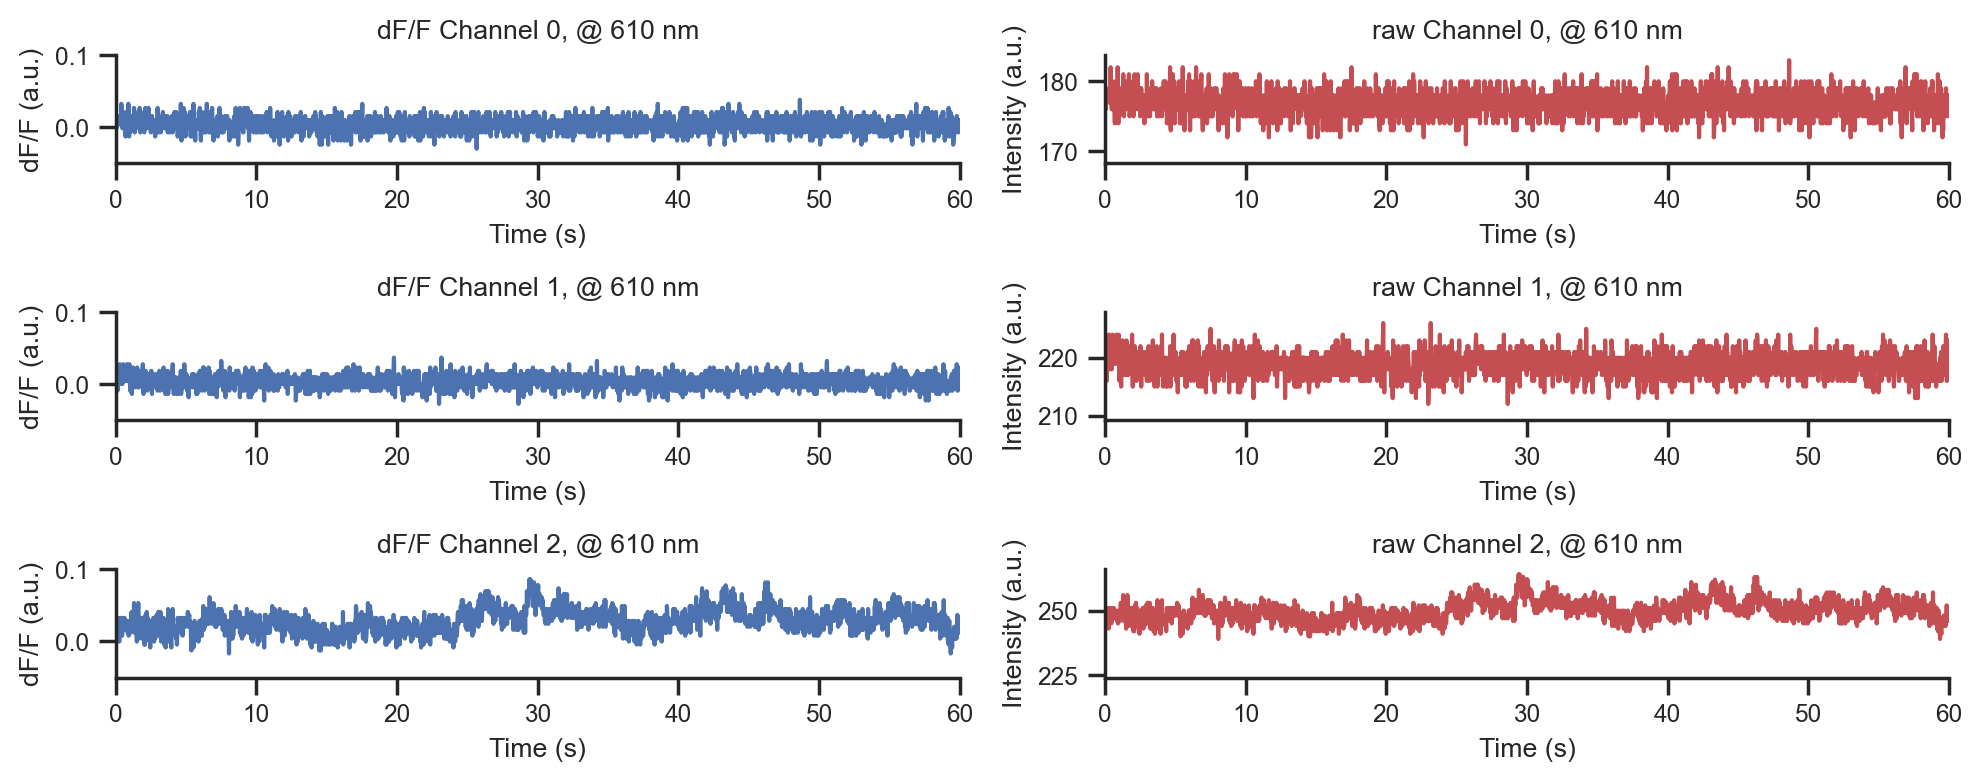


Ca signal is excited by the 473 laser, and emitted at 530 nm 
       Here: channel 1 seems to be the 473 nm laser


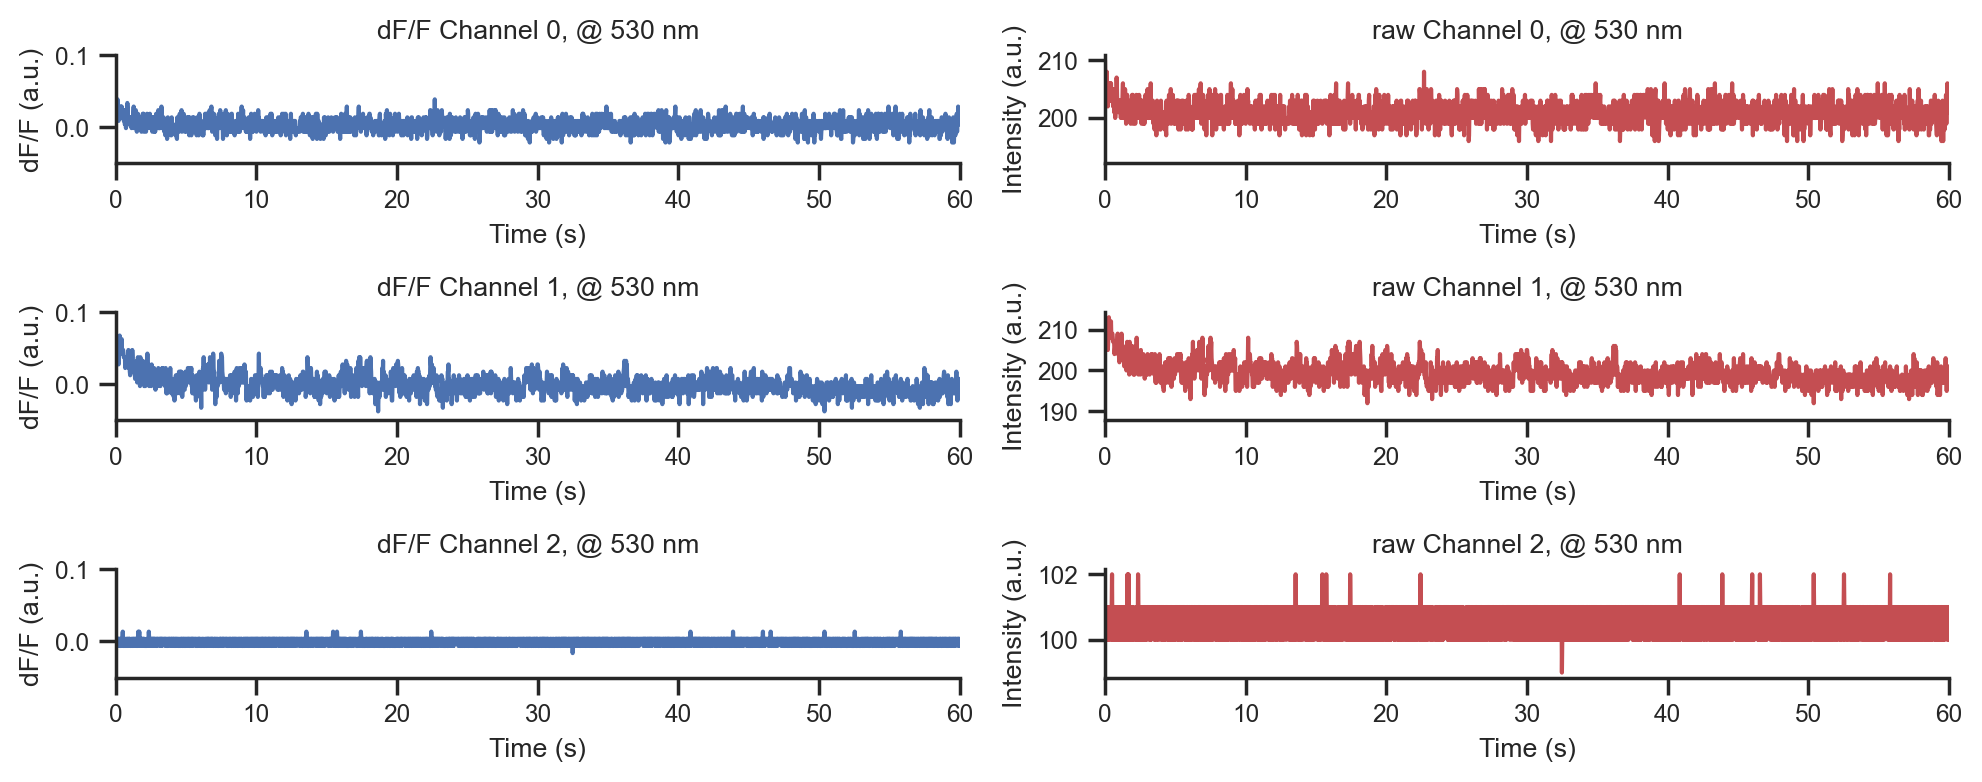


405 laser does not excite either sensor 
       Based on previous two assignments this is channel 3


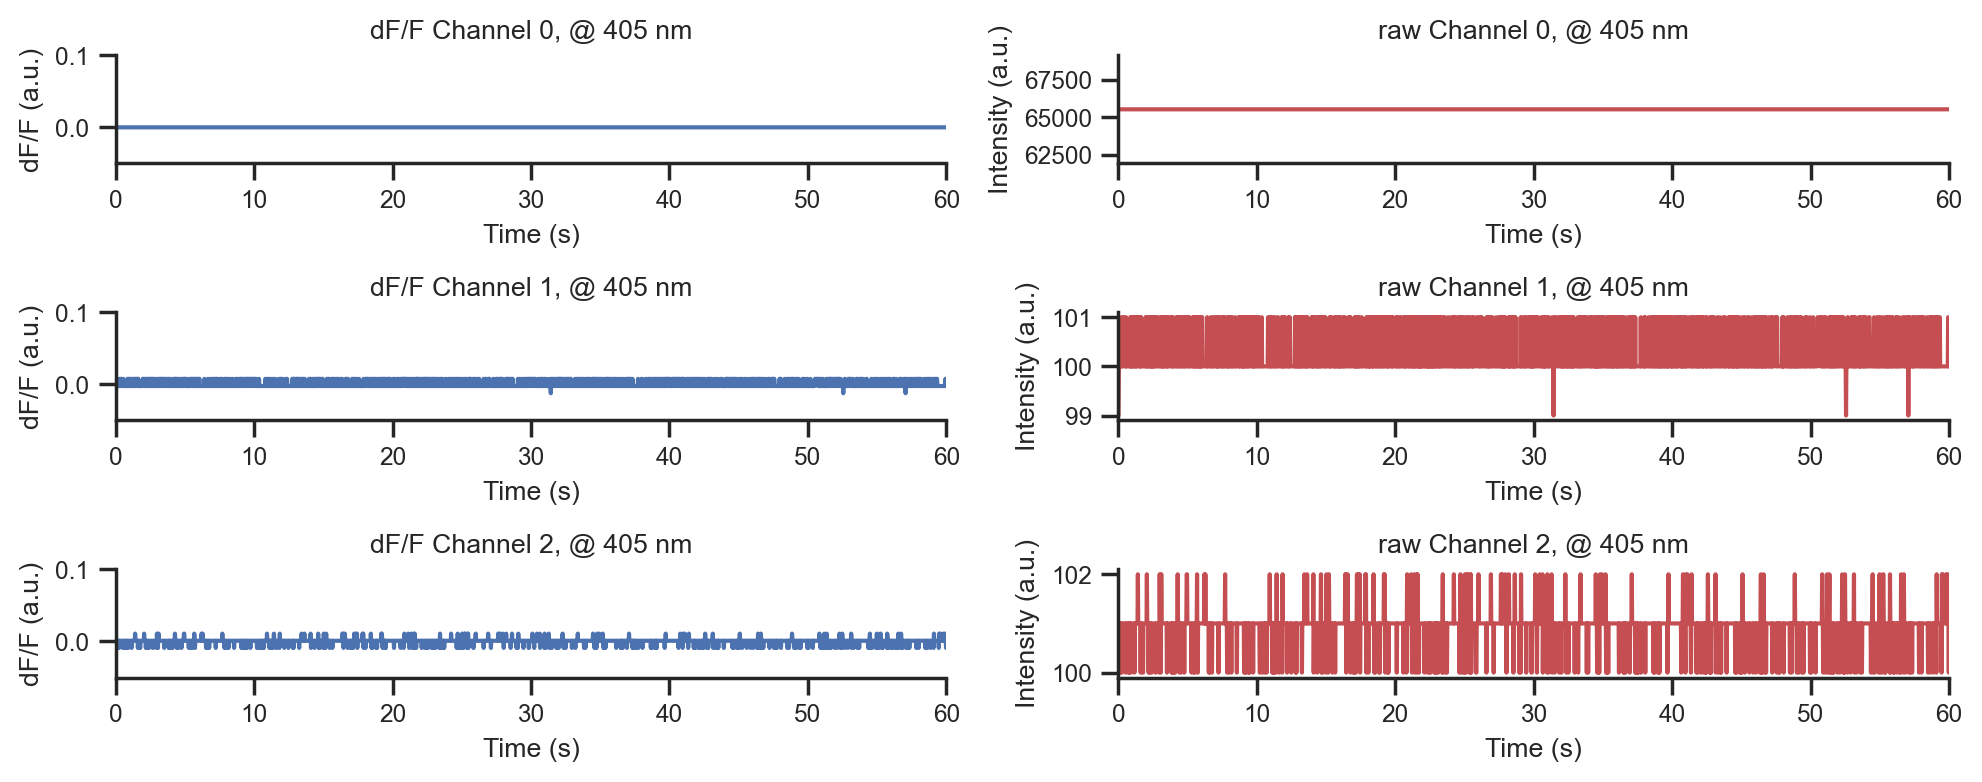

In [7]:
# Channels correspond to different lasers
# The lasers used are:
# channel 2 - em_wavelength_nm = 561
# channel 1 - em_wavelength_nm = 473
# channel 0 - em_wavelength_nm = 405


def df_over_f(x):
    mean_x = np.mean(x)
    return (x - mean_x) / mean_x


def plot_channels(l, t, xj, em_freq, xlim=(0, 60)):
    f, ax = plt.subplots(3, 2, figsize=(10, 4))
    k = 0
    for i in range(3):
        ax[i, k].plot(t.ravel(), df_over_f(xj[i][:, l == em_freq].ravel()))
        ax[i, k].set(
            xlim=xlim,
            ylim=(-0.05, 0.1),
            xlabel="Time (s)",
            ylabel="dF/F (a.u.)",
            title=f"dF/F Channel {i}, @ {em_freq} nm",
        )
    k = 1
    for i in range(3):
        ax[i, k].plot(t.ravel(), xj[i][:, l == em_freq].ravel(), c="r")
        ax[i, k].set(xlim=xlim, xlabel="Time (s)", ylabel="Intensity (a.u.)", title=f"raw Channel {i}, @ {em_freq} nm")

    plt.tight_layout()
    plt.show()
    return


print(
    "DA signal is excited by the 560 laser, and peak emission is at ~610 nm \n \
      Here: channel 2 seems to be the 560 nm laser"
)
plot_channels(l, t, xj, em_freq=610, xlim=(0, 60))

print(
    "\nCa signal is excited by the 473 laser, and emitted at 530 nm \n \
      Here: channel 1 seems to be the 473 nm laser"
)
plot_channels(l, t, xj, em_freq=530, xlim=(0, 60))

print(
    "\n405 laser does not excite either sensor \n \
      Based on previous two assignments this is channel 3"
)
plot_channels(l, t, xj, em_freq=405, xlim=(0, 60))

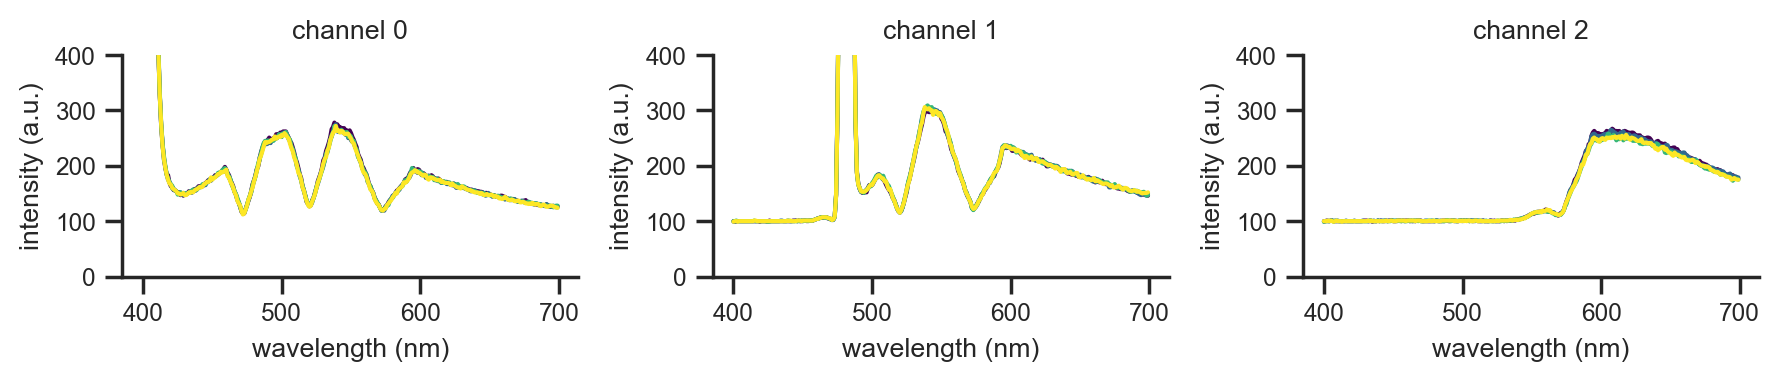

In [8]:
# taking slices within time window `t_window` that have the maximum value in the 500 to 700 nm range
# my expectation is that the dominant signal should be the one from the indicator excited most by the laser of the corresponding channel
# t_window is large enough (60 seconds) to capture one of the 'spikes', where the indicator signal would be the strongest
# Averaging such slices should give a good estimate of the indicator spectrum
# This turns out to be not too different from the overall time average (calculated subsequently)

t_window = 120.0  # in seconds
l_ind = np.arange(l.size)
l_ind = l_ind[l[l_ind] > 500]
J = 3
max_xj = [None] * J

for j in range(J):
    X = xj[j][:, l_ind]
    row_inds = []
    for t_start in np.arange(0, np.max(t), t_window):
        t_end = t_start + np.min([t_window, np.max(t) - t_start])
        ind = np.where((t >= t_start) & (t < t_end))[0]
        ind_max = np.argmax(X[ind, :])
        r, c = np.unravel_index(ind_max, (ind.size, X.shape[1]))
        row_inds.append(ind[r])
    max_xj[j] = xj[j][row_inds, :]

f, ax = plt.subplots(1, 3, figsize=(9, 2))
for j in range(J):
    ax[j].set_prop_cycle("color", plt.cm.viridis(np.linspace(0, 1, max_xj[j].shape[0])))
    ax[j].plot(l.flatten(), max_xj[j].T)
    ax[j].set(xlabel="wavelength (nm)", ylabel="intensity (a.u.)", ylim=(0, 400), title=f"channel {j}")
plt.tight_layout()
plt.show()

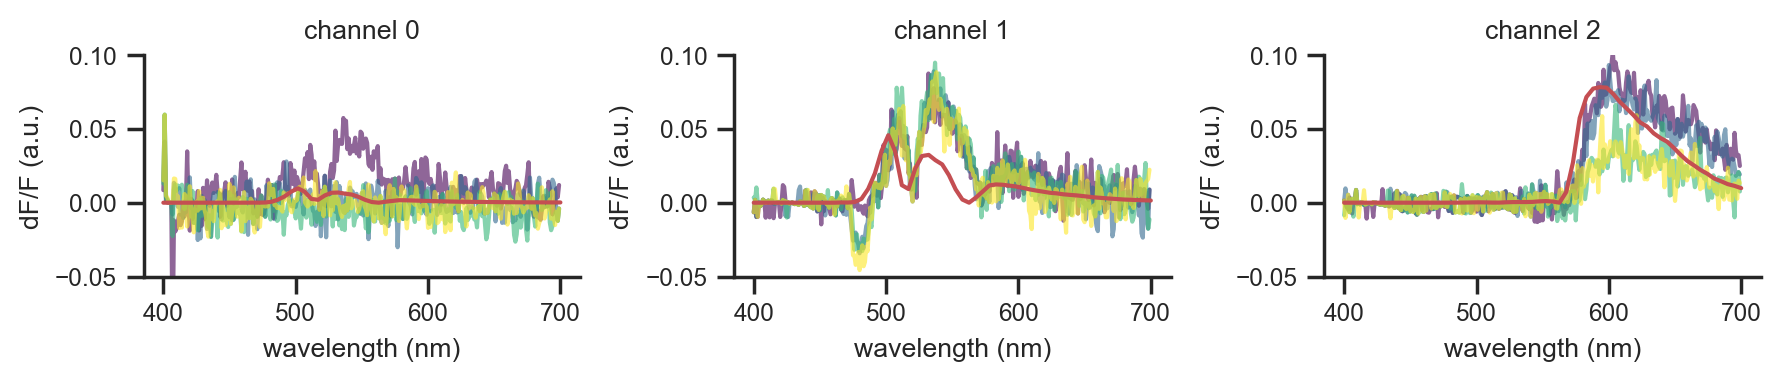

In [9]:
# same as before, but now considering df/f

t_window = 120.0
l_ind = np.arange(l.size)
l_ind = l_ind[l[l_ind] > 500]
J = 3


def df_over_f_ax0(x):
    mean_x = np.mean(x, axis=0, keepdims=True)
    return (x - mean_x) / mean_x


max_xj = [None] * J
Xj = [df_over_f_ax0(xj[j]) for j in range(J)]
for j in range(J):
    # X = df_over_f_ax0(xj[j][:, l_ind])
    X = Xj[j]
    row_inds = []
    for t_start in np.arange(0, np.max(t), t_window):
        t_end = t_start + np.min([t_window, np.max(t) - t_start])
        ind = np.where((t >= t_start) & (t < t_end))[0]
        ind_max = np.argmax(X[ind, :])
        r, c = np.unravel_index(ind_max, (ind.size, X.shape[1]))
        row_inds.append(ind[r])
    max_xj[j] = Xj[j][row_inds, :]

f, ax = plt.subplots(1, 3, figsize=(9, 2))
for j in range(J):
    # use a sequential colormap
    ax[j].set_prop_cycle("color", plt.cm.viridis(np.linspace(0, 1, max_xj[j].shape[0])))
    ax[j].plot(l.flatten(), max_xj[j].T, alpha=0.6)
    ax[j].set(xlabel="wavelength (nm)", ylabel="dF/F (a.u.)", ylim=(-0.05, 0.1), title=f"channel {j}")
    ax[j].plot(sim.L_arr, 0.1 * S_notch[j, :], "-r", label="known emission")
plt.tight_layout()
plt.show()

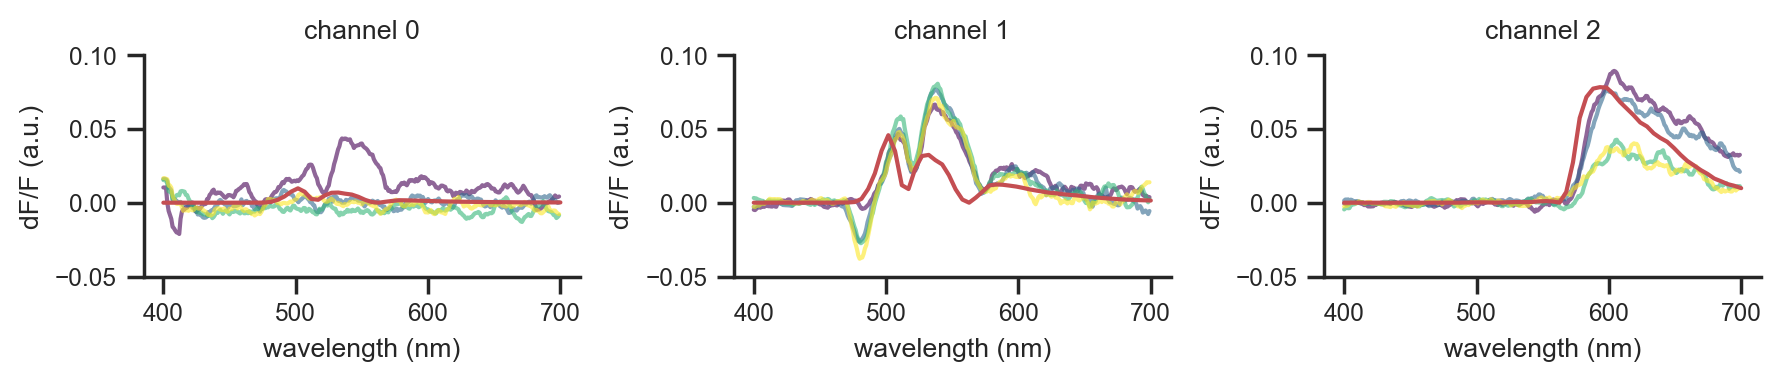

In [10]:
conv_window = 10  # in nm
lam_sampling_rate = np.mean(np.diff(l))
max_xj_conv = max_xj.copy()
for j in range(3):
    max_xj_conv[j] = uniform_filter1d(max_xj_conv[j], int(conv_window / lam_sampling_rate), axis=1)

f, ax = plt.subplots(1, 3, figsize=(9, 2))
for j in range(J):
    # use a sequential colormap
    ax[j].set_prop_cycle("color", plt.cm.viridis(np.linspace(0, 1, max_xj[j].shape[0])))
    ax[j].plot(l.flatten(), max_xj_conv[j].T, alpha=0.6)
    ax[j].set(xlabel="wavelength (nm)", ylabel="dF/F (a.u.)", ylim=(-0.05, 0.1), title=f"channel {j}")
    ax[j].plot(sim.L_arr, 0.1 * S_notch[j, :], "-r", label="known emission")
plt.tight_layout()
plt.show()

In [11]:
J = 3
L = 300
from tqdm import tqdm


def coef_fn(x, y):
    c = np.dot(x - np.mean(x), y - np.mean(y)) / np.size(x)
    c = c / (np.std(x) * np.std(y) + 1e-10)
    return c


coef_list = []
for j in range(J):
    coef = np.empty((L, L))
    coef[:] = np.nan
    for l1 in tqdm(range(L)):
        for l2 in range(l1, L):
            coef[l1, l2] = coef_fn(xj[j][:, l1], xj[j][:, l2])
    coef_list.append(coef)

100%|██████████| 300/300 [00:59<00:00,  5.00it/s]


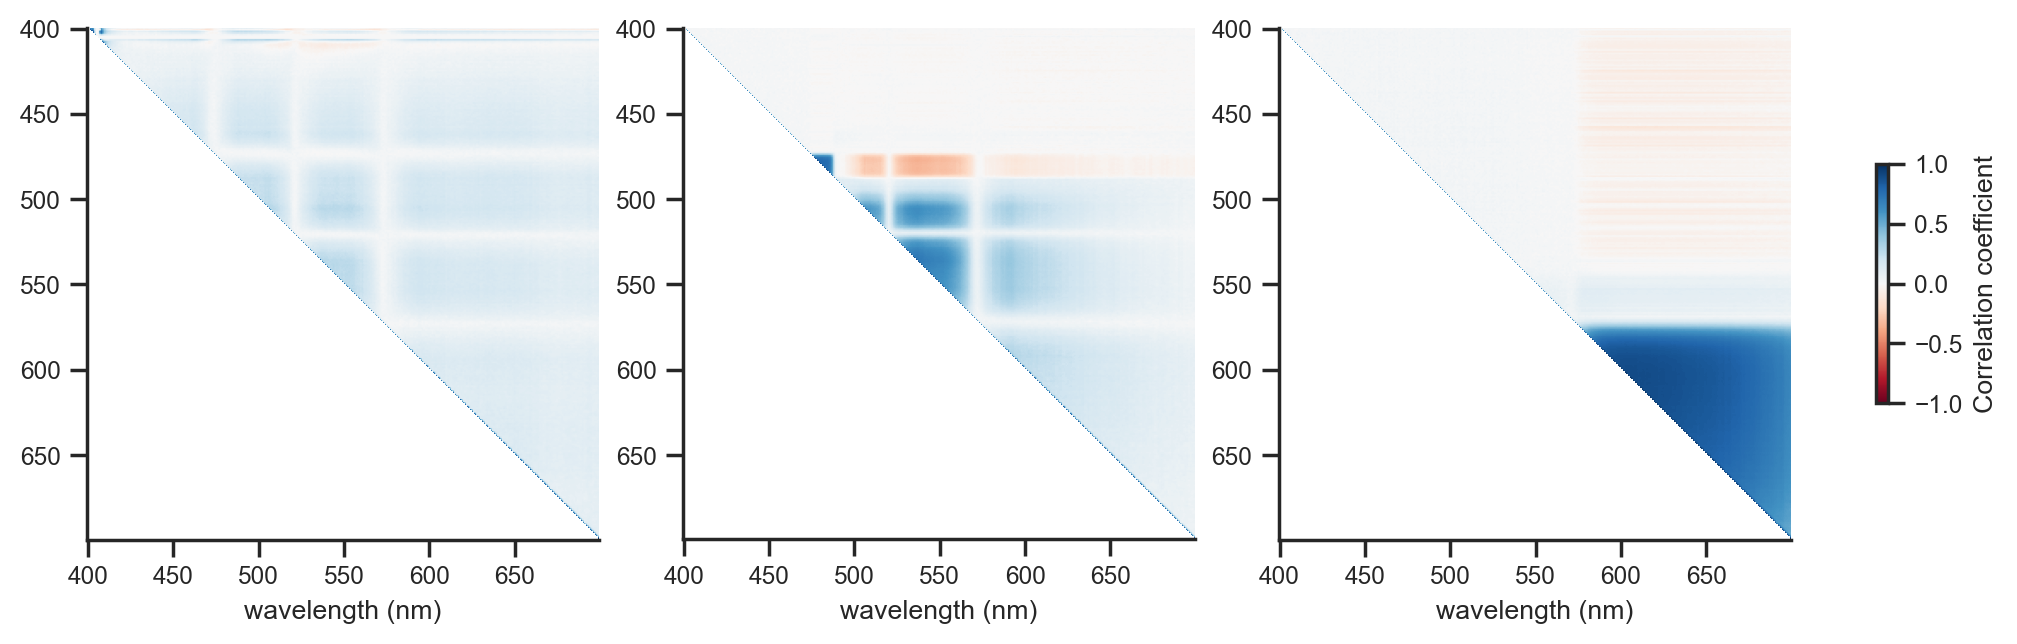

In [12]:
cmap = plt.get_cmap("RdBu").copy()
cmap.set_bad(color="w", alpha=1.0)
f, ax = plt.subplots(1, J, figsize=(10, 10 * J), constrained_layout=True)
for j in range(J):
    i = ax[j].imshow(coef_list[j], vmin=-1, vmax=1, aspect=1, cmap=cmap)
    ax[j].grid(visible=False)
    ax[j].set(xlabel="wavelength (nm)")
    ax[j].set_xticks(np.arange(0, 300, 50), labels=l[np.arange(0, 300, 50)])
    ax[j].set_yticks(np.arange(0, 300, 50), labels=l[np.arange(0, 300, 50)])
f.colorbar(i, ax=ax[:], location="right", shrink=0.04, label="Correlation coefficient")
plt.show()

In [ ]:
# parallelizing this in this way doesn't help much.
# could try to distribute the work on a per-row basis
# or could paralellize over j
# next: parallelize this over rows

J = 3
L = 300


def coef_fn(args):
    x, y, i, j = args
    c = np.dot(x - np.mean(x), y - np.mean(y)) / np.size(x)
    c = c / (np.std(x) * np.std(y) + 1e-10)
    return c, i, j


def data_gen(xj, L):
    for l1 in range(L):
        for l2 in range(l1, L):
            yield (xj[0][:, l1], xj[0][:, l2], l1, l2)


for processes in [2, 4, 8]:
    dat = data_gen(xj, L)
    coef_list_par = []
    for j in range(1):
        with timebudget(f"parallel processes: {processes}"):
            with Pool(processes=processes) as pool:
                results = pool.map(coef_fn, dat)
            coef_list_par.append(results)